In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [2]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
NO_PARAMETRIC_FOLDER = 'no-parametric'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [3]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'genero':[] 
}

In [4]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [5]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [6]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [7]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [8]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [9]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [10]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [11]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.897959,4.645833,4.469388,3.000000,3.836735,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.979592,4.680851,4.551020,4.183673,4.224490,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.346939,3.926829,2.816327,1.775510,1.653061,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.693878,4.304348,4.244898,2.979592,3.755102,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.571429,4.113636,3.183673,1.836735,1.591837,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVR

### Inteligibilidad

In [13]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [14]:
mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [15]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0,)


In [16]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
      
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')


ZCR p-valor: 0.006993006993006993
RMS p-valor: 0.25874125874125875
f0 p-valor: 0.09290709290709291


In [17]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [18]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.33 * ZCR + 4.73 - p-valor = 0.007


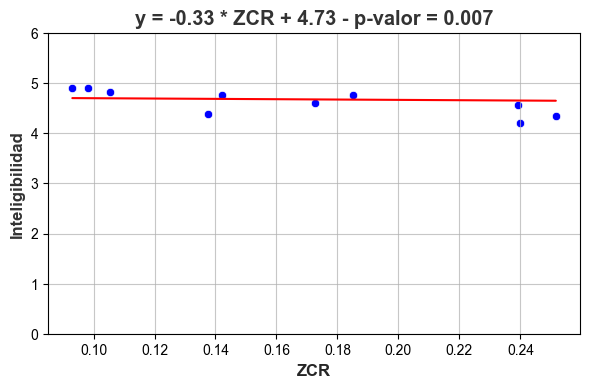

In [19]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [20]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html'))

    fig.show()


#### Femenino

In [21]:
mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [22]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 1, 2)


In [23]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')


ZCR p-valor: 0.14885114885114886
RMS p-valor: 0.1048951048951049
f0 p-valor: 0.4905094905094905


In [24]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [25]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.27 * ZCR + 4.80 - p-valor = 0.149
y = 0.08 * RMS + 7.02 - p-valor = 0.105
y = -0.01 * $f_{0}$ + 5.42 - p-valor = 0.491


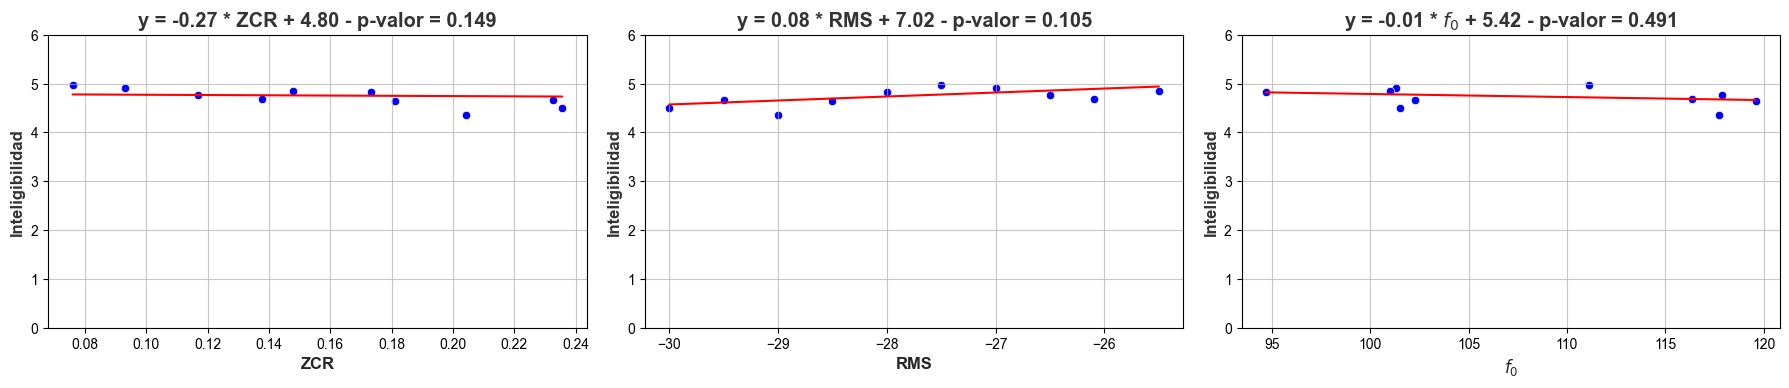

In [26]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [27]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )

    fig.show()


### Pronunciacion

In [28]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [29]:
mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [30]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0,)


In [31]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')


ZCR p-valor: 0.1038961038961039
RMS p-valor: 0.8001998001998002
f0 p-valor: 0.1958041958041958


In [32]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [33]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.39 * ZCR + 4.44 - p-valor = 0.104


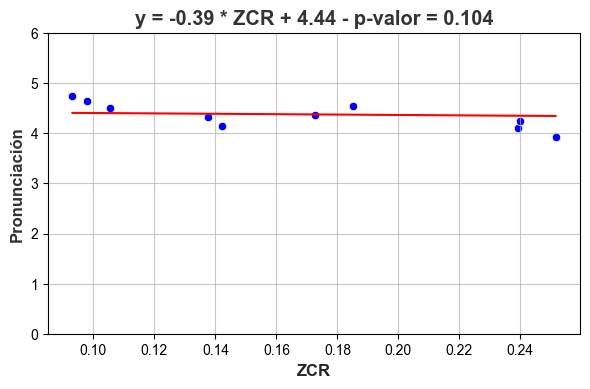

In [34]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [35]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html'))

    fig.show()


#### Femenino

In [36]:
mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [37]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 1, 2)


In [38]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')


ZCR p-valor: 0.44555444555444557
RMS p-valor: 0.3626373626373626
f0 p-valor: 0.3436563436563437


In [39]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [40]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.18 * ZCR + 4.47 - p-valor = 0.446
y = 0.05 * RMS + 5.73 - p-valor = 0.363
y = -0.01 * $f_{0}$ + 5.06 - p-valor = 0.344


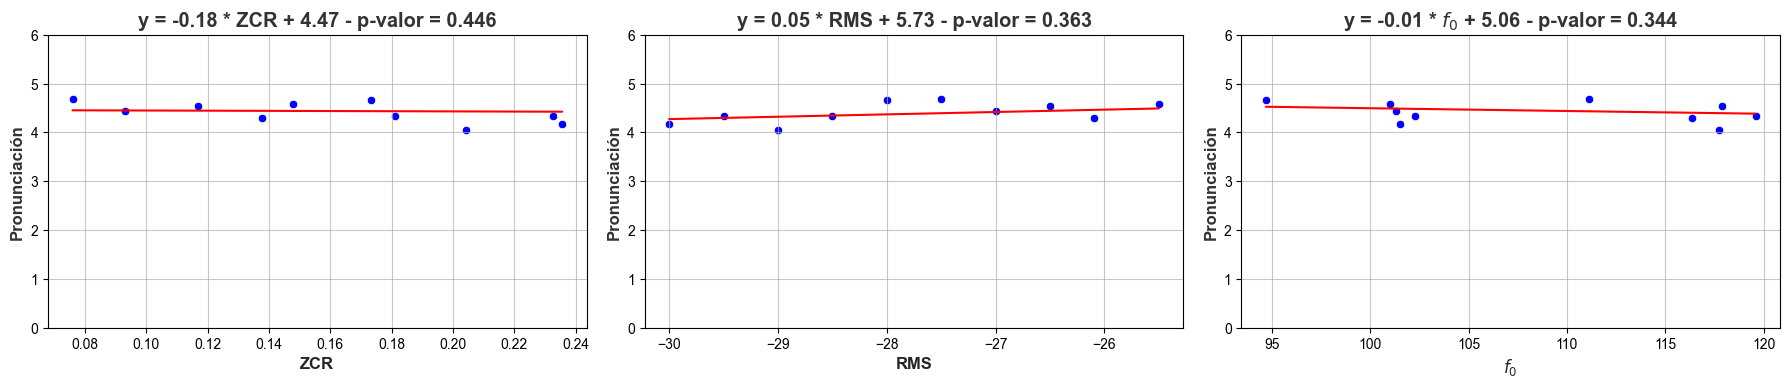

In [41]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [42]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html'))

    fig.show()


### Acentuacion

In [43]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [44]:
mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [45]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 2)


In [46]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')


ZCR p-valor: 0.17082917082917082
RMS p-valor: 0.6003996003996004
f0 p-valor: 0.13486513486513488


In [47]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [48]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.39 * ZCR + 3.96 - p-valor = 0.171
y = -0.04 * $f_{0}$ + 7.09 - p-valor = 0.135


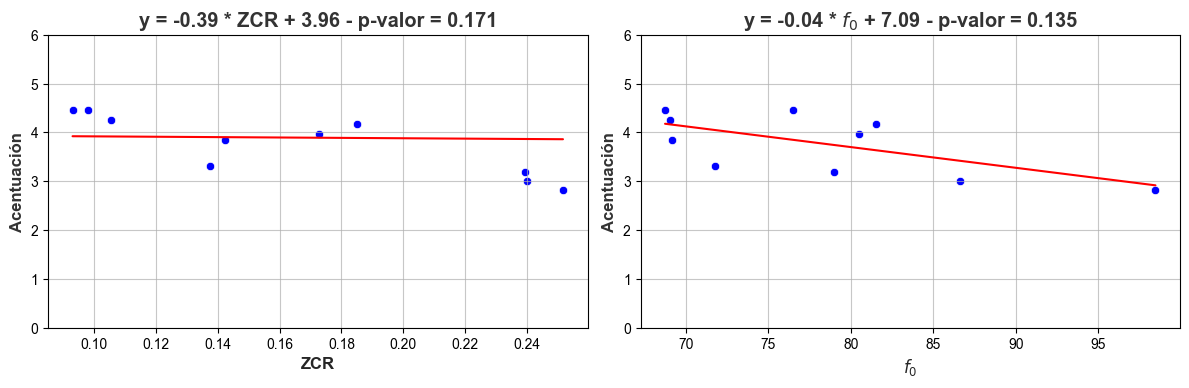

In [49]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [50]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html'))

    fig.show()


#### Femenino

In [51]:
mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [52]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (1, 2)


In [53]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')


ZCR p-valor: 0.5534465534465535
RMS p-valor: 0.04895104895104895
f0 p-valor: 0.3836163836163836


In [54]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [55]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.17 * RMS + 8.83 - p-valor = 0.049
y = -0.02 * $f_{0}$ + 6.30 - p-valor = 0.384


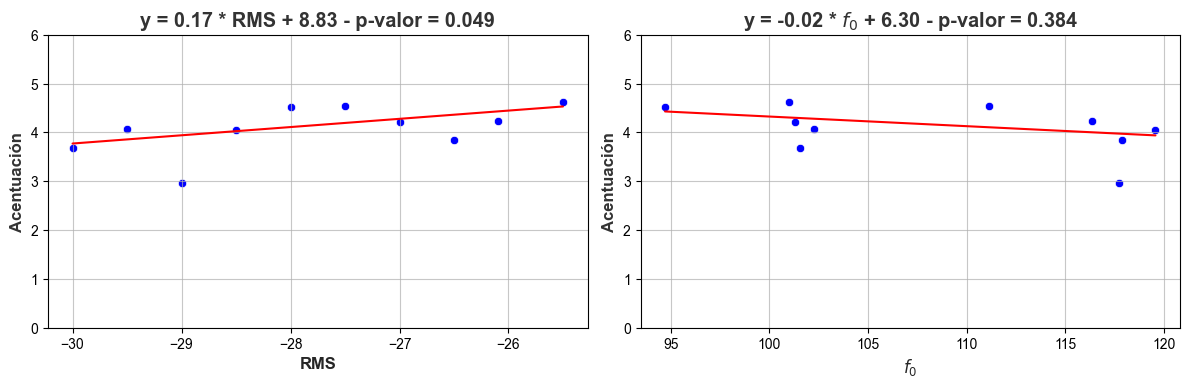

In [56]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [57]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html'))

    fig.show()


### Naturalidad

In [58]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [59]:
mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [60]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (1,)


In [61]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')


ZCR p-valor: 0.014985014985014986
RMS p-valor: 0.011988011988011988
f0 p-valor: 0.012987012987012988


In [62]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [63]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.43 * RMS + 12.54 - p-valor = 0.012


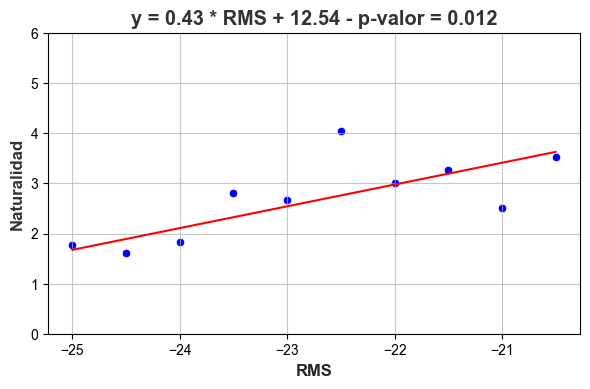

In [64]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [65]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html'))

    fig.show()


#### Femenino

In [66]:
mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [67]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 1, 2)


In [68]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')


ZCR p-valor: 0.43156843156843155
RMS p-valor: 0.01898101898101898
f0 p-valor: 0.23176823176823177


In [69]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [70]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.38 * ZCR + 3.15 - p-valor = 0.432
y = 0.37 * RMS + 13.18 - p-valor = 0.019
y = -0.04 * $f_{0}$ + 7.04 - p-valor = 0.232


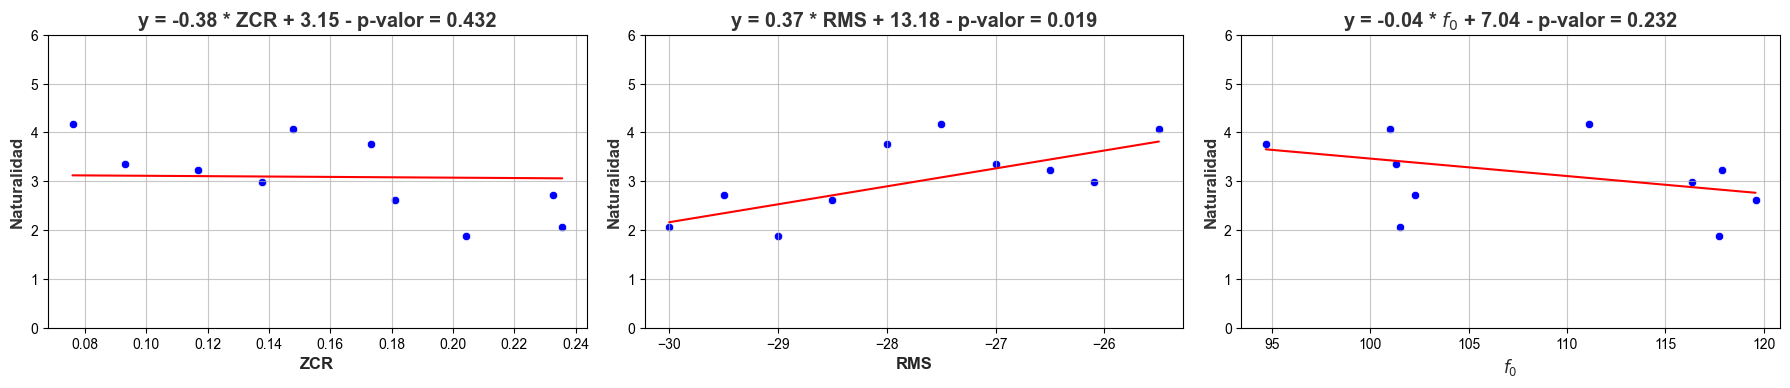

In [71]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [72]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html'))

    fig.show()


### Cadencia

In [73]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [74]:
mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [75]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (0, 2)


In [76]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')


ZCR p-valor: 0.07292707292707293
RMS p-valor: 0.4045954045954046
f0 p-valor: 0.03496503496503497


In [77]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [78]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -0.43 * ZCR + 3.08 - p-valor = 0.073
y = -0.07 * $f_{0}$ + 8.39 - p-valor = 0.035


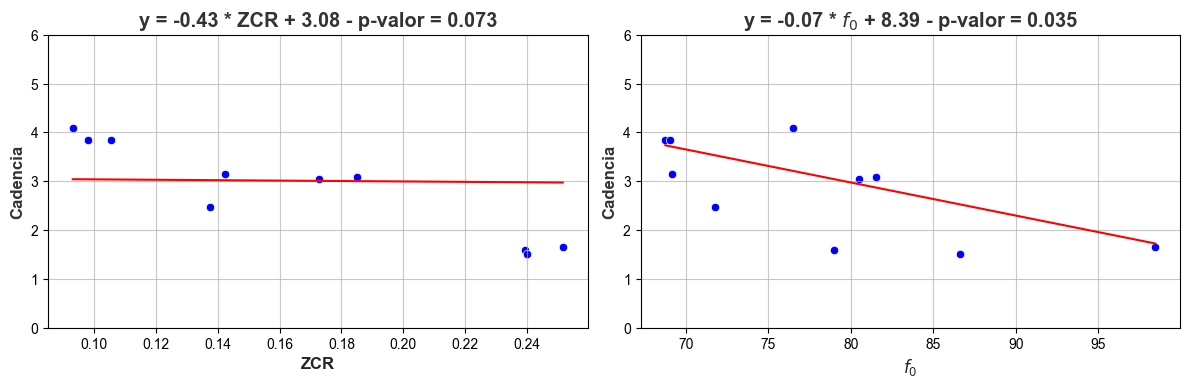

In [79]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [80]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html'))

    fig.show()


#### Femenino

In [81]:
mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [82]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión kNN
regr_multivar = SVR(kernel='linear')

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)


Características seleccionadas: (1, 2)


In [83]:
# Establecemos la semilla aleatoria para reproducibilidad
random_state = check_random_state(0)

p_values = []

for i in range(X.shape[1]):
    
    # Seleccionamos solo una columna en X
    X_single = X[:, i].reshape(-1, 1)
    
    # Aplicamos la prueba de permutación
    score, permutation_scores, pvalue = permutation_test_score(regr_multivar, X_single, y, scoring='neg_mean_squared_error', cv=5, n_permutations=1000, random_state=random_state)
    
    p_values.append(pvalue)

    # Imprimimos el p-valor
    if i == 0:
        var = 'ZCR'
    elif i == 1:
        var = 'RMS'
    else:
        var = 'f0'
    dicc_p_value[var].append(pvalue)
    print(f'{var} p-valor:', pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')


ZCR p-valor: 0.5504495504495505
RMS p-valor: 0.006993006993006993
f0 p-valor: 0.5464535464535465


In [84]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [85]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0][0]
    b = model.intercept_[0]
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.45 * RMS + 15.74 - p-valor = 0.007
y = -0.01 * $f_{0}$ + 5.19 - p-valor = 0.546


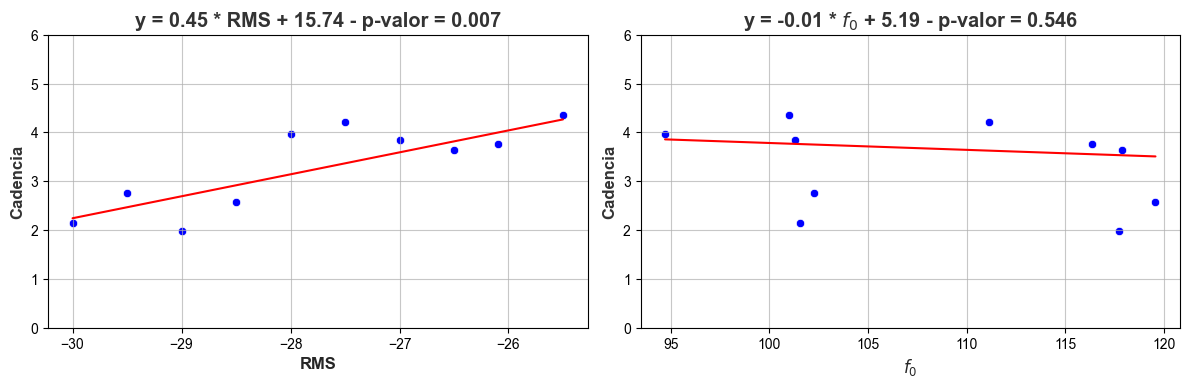

In [86]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [87]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = SVR(kernel='linear')
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_[0].round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[0][i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))

    fig.write_html(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html'))

    fig.show()


## Output p-values regressions

In [88]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [89]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,genero
0,Inteligibilidad,0.006993,0.258741,0.092907,masculino
1,Inteligibilidad,0.148851,0.104895,0.490509,femenino
2,Pronunciación,0.103896,0.800200,0.195804,masculino
3,Pronunciación,0.445554,0.362637,0.343656,femenino
4,Acentuación,0.170829,0.600400,0.134865,masculino
5,Acentuación,0.553447,0.048951,0.383616,femenino
6,Naturalidad,0.014985,0.011988,0.012987,masculino
7,Naturalidad,0.431568,0.018981,0.231768,femenino
8,Cadencia,0.072927,0.404595,0.034965,masculino
9,Cadencia,0.550450,0.006993,0.546454,femenino


In [90]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, NO_PARAMETRIC_FOLDER, 'output_p_values_no_parametric_regressions.xlsx'),
    index=False
)